In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union

## Funciones Globales

In [74]:
# Constants
emotion_translation = {
    "neutral": "neutral",
    "anger": "enojo",
    "surprise": "sorpresa",
    "fear": "miedo",
    "joy": "alegría",
    "sadness": "tristeza",
    "disgust": "repulsión",
    "love": "amor",
    "unknown": "desconocido"
}

emotion_colors = {
    "neutral": "#A9A9A9",      # gris
    "enojo": "#D62728",        # rojo fuerte
    "sorpresa": "#FF7F0E",     # naranja
    "miedo": "#9467BD",        # púrpura
    "alegría": "#2CA02C",      # verde
    "tristeza": "#1F77B4",     # azul
    "repulsión": "#8C564B",    # marrón
    "amor": "#E377C2",         # rosa
    "desconocido": "#7F7F7F"   # gris oscuro
}

In [75]:
def get_emotions_count(df: pd.DataFrame, emotion_column: str = "predicted_emotion") -> Union[pd.DataFrame, None]:
    """
    Computes the count of each emotion in the specified column of a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the emotion data.
        emotion_column (str): The name of the column containing emotion labels. Default is "emotion".

    Returns:
        pd.DataFrame: A DataFrame with emotions and their counts, sorted by count in descending order.
        None: If the input DataFrame is empty or the specified column is missing.
    """
    if emotion_column not in df.columns:
        print(f"Error: Column '{emotion_column}' not found in the DataFrame.")
        return None

    if df.empty:
        print("Error: The input DataFrame is empty.")
        return None

    # Normalize and count emotions
    emotion_counts = df[emotion_column].str.lower().str.strip().value_counts()

    # Create a DataFrame from the counts
    emotions_df = emotion_counts.reset_index()
    emotions_df.columns = ["Emoción", "Cantidad"]

    # Sort the DataFrame by count in descending order
    emotions_df = emotions_df.sort_values(by="Cantidad", ascending=False).reset_index(drop=True)

    return emotions_df

def translate_emotions(df: pd.DataFrame, emotion_column: str = "predicted_emotion") -> pd.DataFrame:
    """
    Translates emotions in the specified column of a DataFrame to Spanish.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the emotion data.
        emotion_column (str): The name of the column containing emotion labels. Default is "predicted_emotion".

    Returns:
        pd.DataFrame: A DataFrame with the translated emotions.
    """
    if emotion_column not in df.columns:
        print(f"Error: Column '{emotion_column}' not found in the DataFrame.")
        return df

    # Translate emotions using the mapping
    df[emotion_column] = df[emotion_column].str.lower().map(emotion_translation).fillna(df[emotion_column])

    return df

def plot_emotions_count(df: pd.DataFrame, title: str = "Conteo de emociones") -> None:
    """
    Plots the count of emotions from a DataFrame and displays values on the bars.

    Parameters:
        df (pd.DataFrame): The DataFrame containing emotion counts with 'Emoción' and 'Cantidad' columns.
        title (str): The title of the plot. Default is "Conteo de emociones".
    """
    colors = [emotion_colors.get(emocion, "gray") for emocion in df["Emoción"]]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(df["Emoción"], df["Cantidad"], color=colors, alpha=0.5)
    plt.xlabel("Cantidad")
    plt.title(title)
    plt.gca().invert_yaxis()

    # Añadir los valores sobre cada barra
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 10000, bar.get_y() + bar.get_height()/2,
                 f'{int(width):,}', va='center')

    # Quitar bordes superior y derecho
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [76]:
def process_emotion_counts_by_period(
    df: pd.DataFrame,
    period: str = "D",  # "D"=diario, "W"=semanal, "M"=mensual
    time_column: str = "created_time",
    emotion_column: str = "predicted_emotion"
) -> pd.DataFrame:
    """
    Agrupa los conteos de emociones por un periodo determinado.

    Parameters:
        df (pd.DataFrame): DataFrame de entrada.
        period (str): "D" (día), "W" (semana), o "M" (mes).
        time_column (str): Nombre de la columna de fecha.
        emotion_column (str): Nombre de la columna de emociones.

    Returns:
        pd.DataFrame: DataFrame con conteos por periodo.
    """
    df[time_column] = pd.to_datetime(df[time_column])
    df["period"] = df[time_column].dt.to_period(period).apply(lambda r: r.start_time)
    emotion_counts = df.groupby(["period", emotion_column]).size().unstack(fill_value=0)
    return emotion_counts.sort_index()

def plot_emotion_counts_by_period(
    emotion_counts: pd.DataFrame,
    title: str = "Evolución de emociones",
    ylabel: str = "Cantidad"
) -> None:
    """
    Grafica los conteos de emociones por periodo.
    """
    plt.figure(figsize=(14, 6))
    available_emotions = [e for e in emotion_colors if e in emotion_counts.columns]
    colors = [emotion_colors[e] for e in available_emotions]

    emotion_counts[available_emotions].plot(kind="line", color=colors, figsize=(15, 6))

    plt.title(title)
    plt.xlabel("Periodo")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Emoción")
    plt.tight_layout()
    plt.show()

def plot_emotion_proportions_by_period(
    emotion_counts: pd.DataFrame,
    title: str = "Proporción de emociones por periodo"
) -> None:
    """
    Grafica las proporciones de emociones por periodo.
    """
    proportions = emotion_counts.div(emotion_counts.sum(axis=1), axis=0)

    plt.figure(figsize=(14, 6))
    available_emotions = [e for e in emotion_colors if e in proportions.columns]
    colors = [emotion_colors[e] for e in available_emotions]

    proportions[available_emotions].plot(kind="line", color=colors, figsize=(15, 6))

    plt.title(title)
    plt.xlabel("Periodo")
    plt.ylabel("Proporción")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Emoción")
    plt.tight_layout()
    plt.show()

In [122]:
def get_dominant_emotion_per_period(emotion_counts: pd.DataFrame) -> pd.Series:
    """
    Devuelve la emoción predominante por periodo.
    """
    return emotion_counts.idxmax(axis=1)



def plot_dominant_emotion(
    emotion_counts: pd.DataFrame,
    title: str = "Emoción dominante por periodo",
    x_label: str = "Periodo",
    period_type: str = "semana",
    exclude_emotions: list = None
) -> pd.DataFrame:
    """
    Grafica la emoción dominante para cada periodo.

    Parameters:
        emotion_counts (pd.DataFrame): DataFrame con conteos de emociones por periodo
        title (str): Título del gráfico
        x_label (str): Etiqueta del eje X
        period_type (str): Tipo de periodo ("día", "semana", "mes") para el título
        exclude_emotions (list): Lista de emociones a excluir del análisis (por ejemplo, ["neutral"])

    Returns:
        pd.DataFrame: DataFrame con las emociones dominantes por periodo
    """
    # Hacer una copia para evitar modificar el original
    emotion_counts_filtered = emotion_counts.copy()

    # Excluir emociones si se especifican
    if exclude_emotions:
        for emotion in exclude_emotions:
            if emotion in emotion_counts_filtered.columns:
                emotion_counts_filtered = emotion_counts_filtered.drop(columns=[emotion])

    # Obtener emoción dominante por periodo
    dominant_emotions = get_dominant_emotion_per_period(emotion_counts_filtered)

    # Convertir a DataFrame
    df_dominant = dominant_emotions.reset_index()
    df_dominant.columns = ["period", "emotion"]

    # Graficar puntos categóricos
    plt.figure(figsize=(14, 5))
    sns.scatterplot(data=df_dominant, x="period", y="emotion",
                   hue="emotion", palette=emotion_colors, s=100)

    # Si no se especifica un título personalizado, usar uno genérico con el tipo de periodo
    if title == "Emoción dominante por periodo":
        title = f"Emoción dominante por {period_type}"

    # Añadir información sobre emociones excluidas al título si corresponde
    if exclude_emotions:
        excluded_str = ", ".join(exclude_emotions)
        title += f" (excluido: {excluded_str})"

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Emoción")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Emoción", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def get_monthly_proportions(df, model_name):
    # Asegurar tipo datetime
    df["created_time"] = pd.to_datetime(df["created_time"])

    # Agregar columna 'mes'
    df["month"] = df["created_time"].dt.to_period("M").dt.to_timestamp()

    # Calcular conteo mensual por emoción
    monthly_counts = df.groupby(["month", "predicted_emotion"]).size().unstack(fill_value=0)

    # Calcular proporciones por mes
    monthly_props = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

    # Promedio mensual por emoción
    mean_props = monthly_props.mean().sort_values(ascending=False)

    # Mostrar resultado
    print(f"\nProporciones promedio mensuales – {model_name}")
    print(mean_props.round(4))  # Redondeado a 4 decimales

    return mean_props

## Modelo DistilBERT

In [77]:
df_distilbert = pd.read_csv("../data/chunks_distilbert/reddit_emotions.csv")
df_distilbert_translated = translate_emotions(df_distilbert, "predicted_emotion")

df_distilbert_emotion_count = get_emotions_count(df_distilbert_translated, "predicted_emotion")

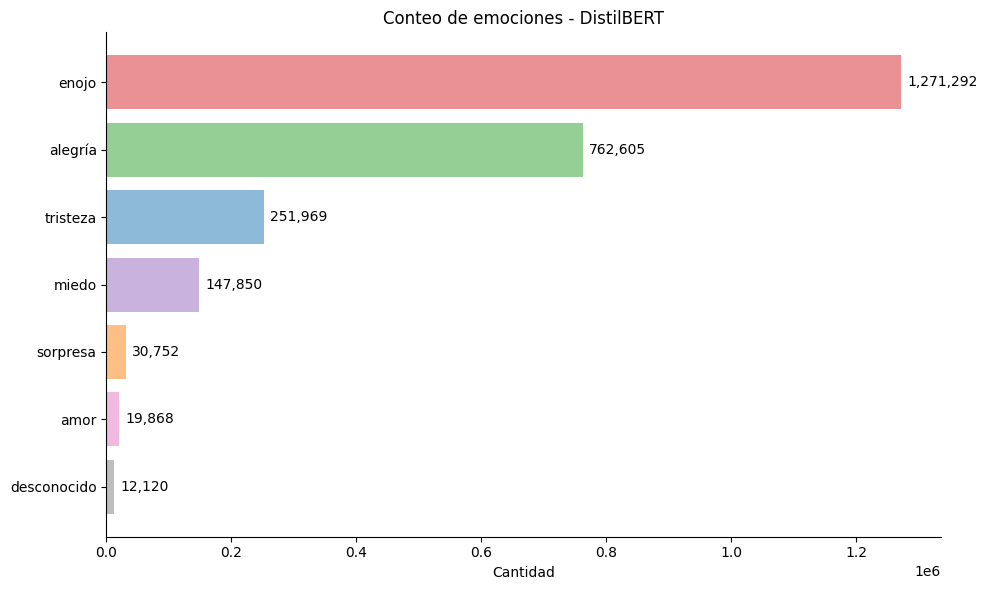

In [78]:
plot_emotions_count(df_distilbert_emotion_count, title="Conteo de emociones - DistilBERT")

<Figure size 1400x600 with 0 Axes>

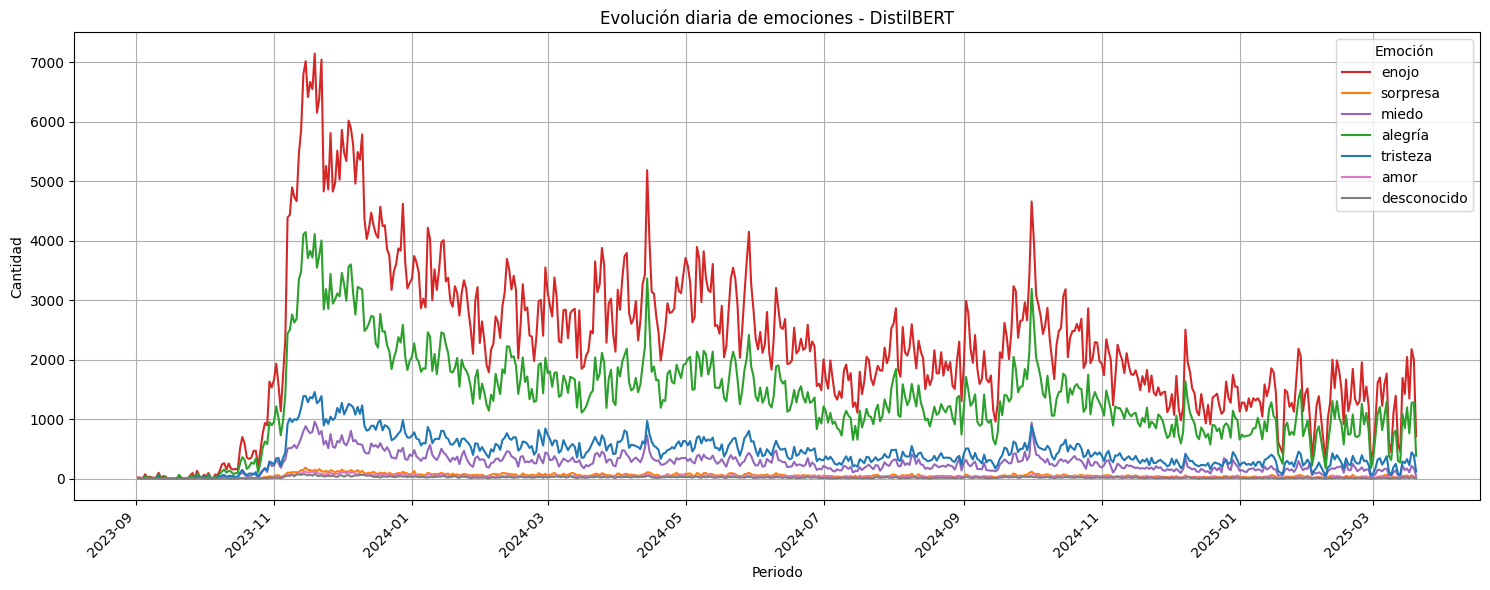

<Figure size 1400x600 with 0 Axes>

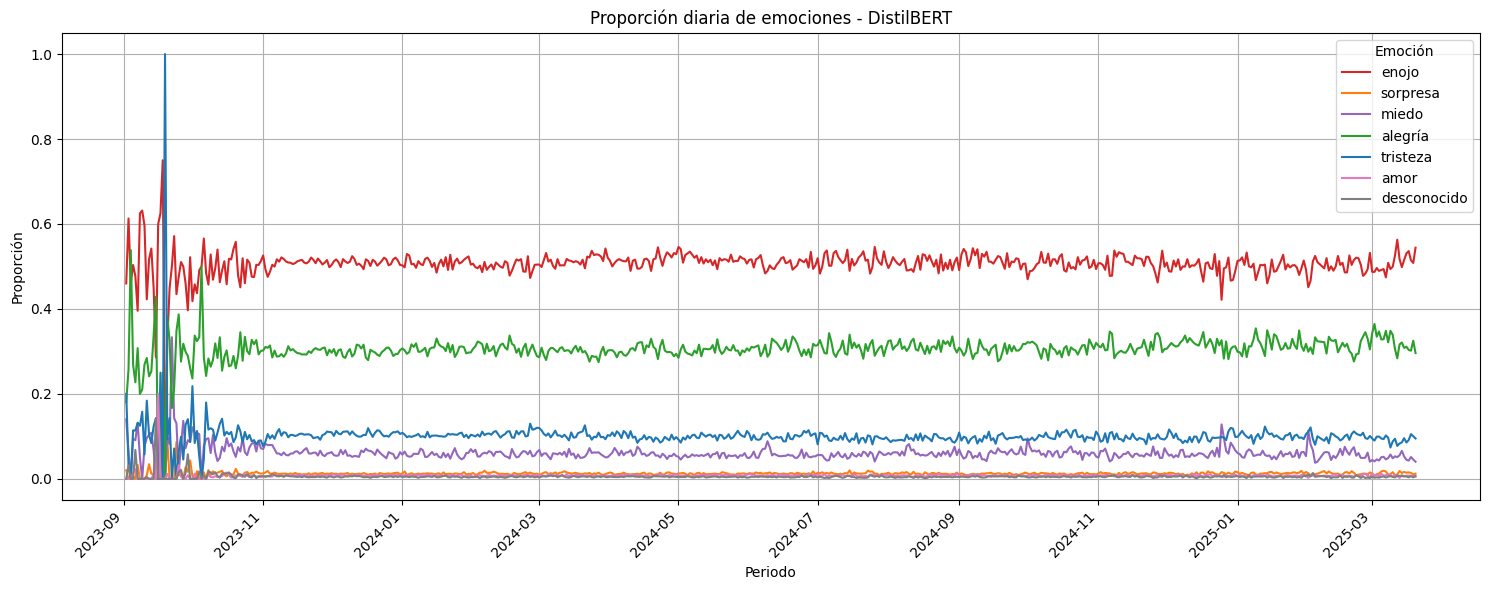

<Figure size 1400x600 with 0 Axes>

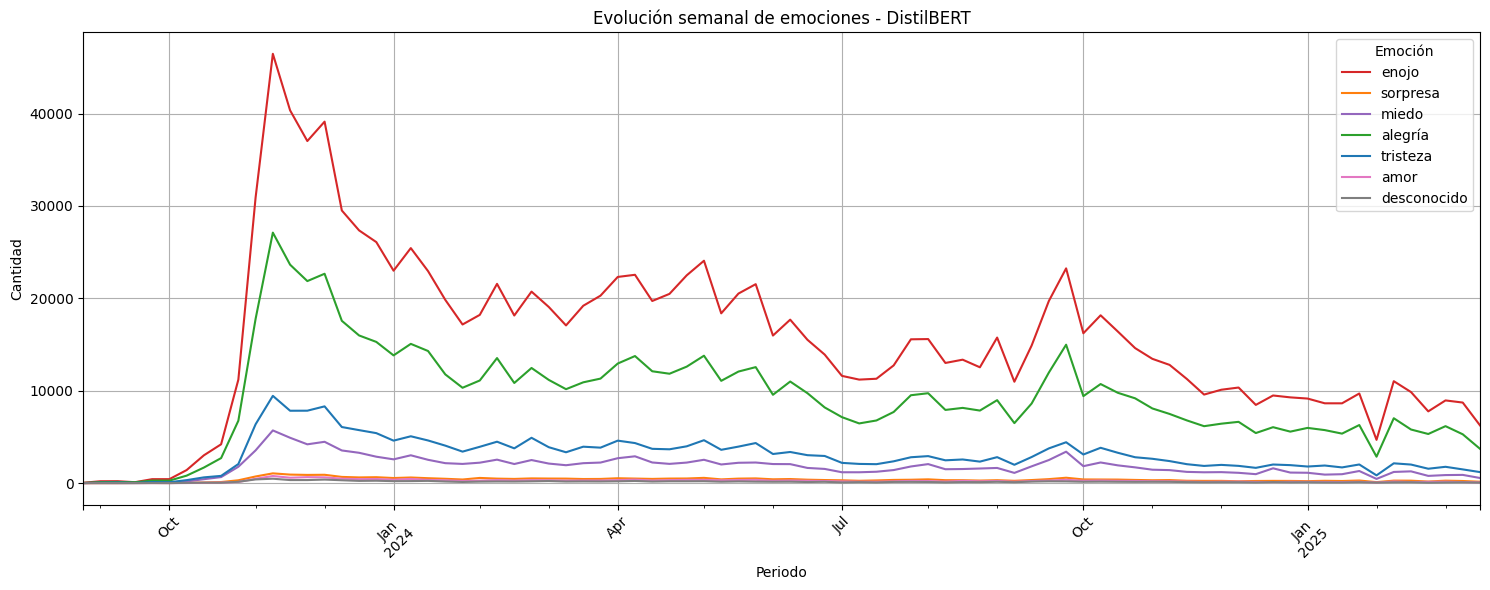

<Figure size 1400x600 with 0 Axes>

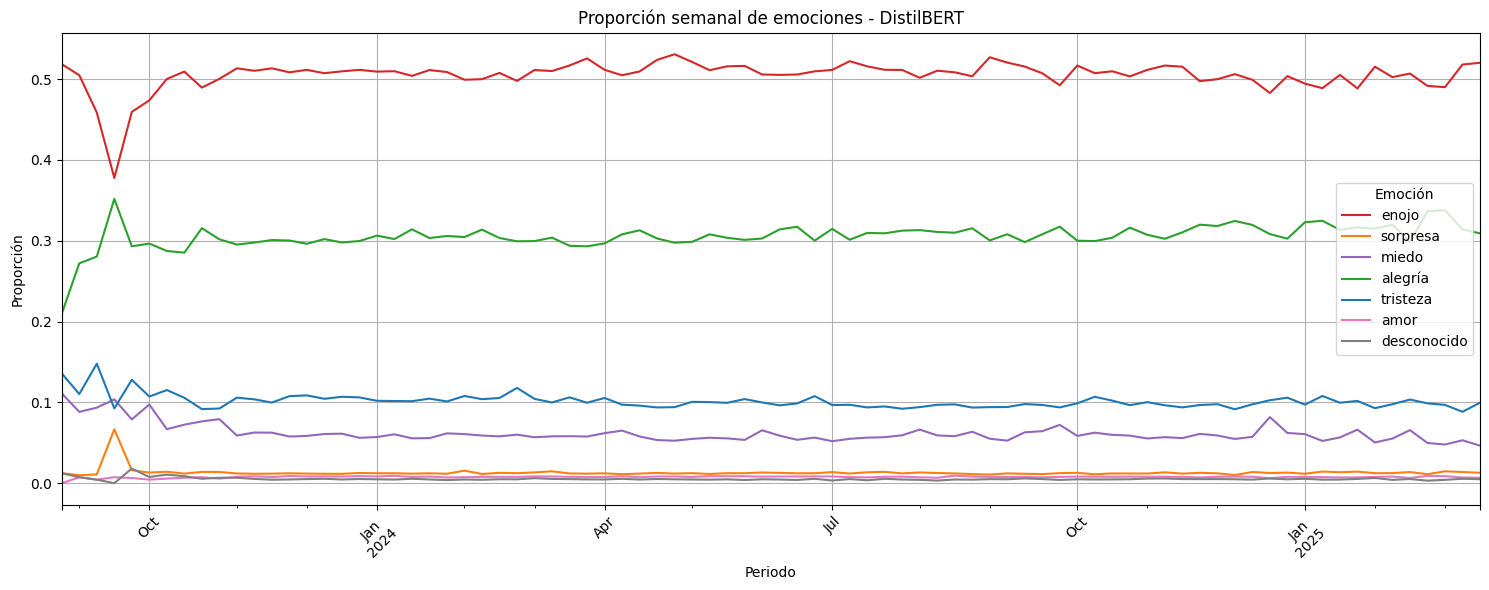

<Figure size 1400x600 with 0 Axes>

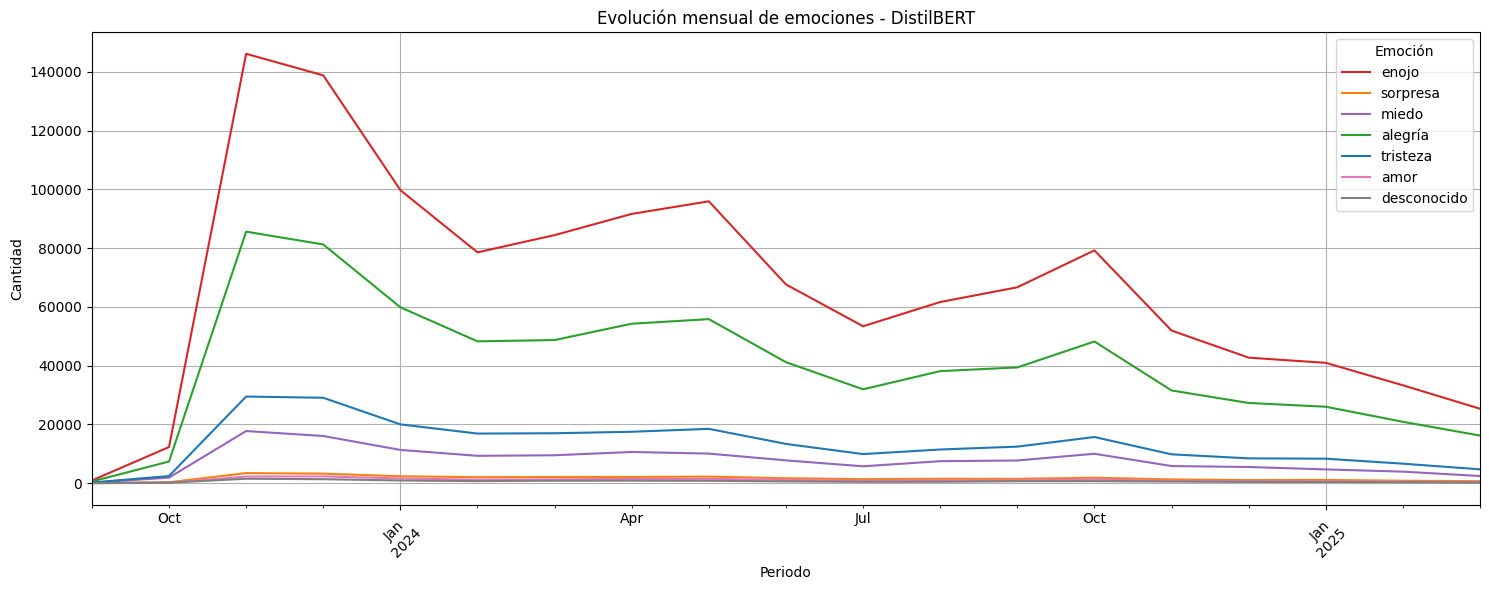

<Figure size 1400x600 with 0 Axes>

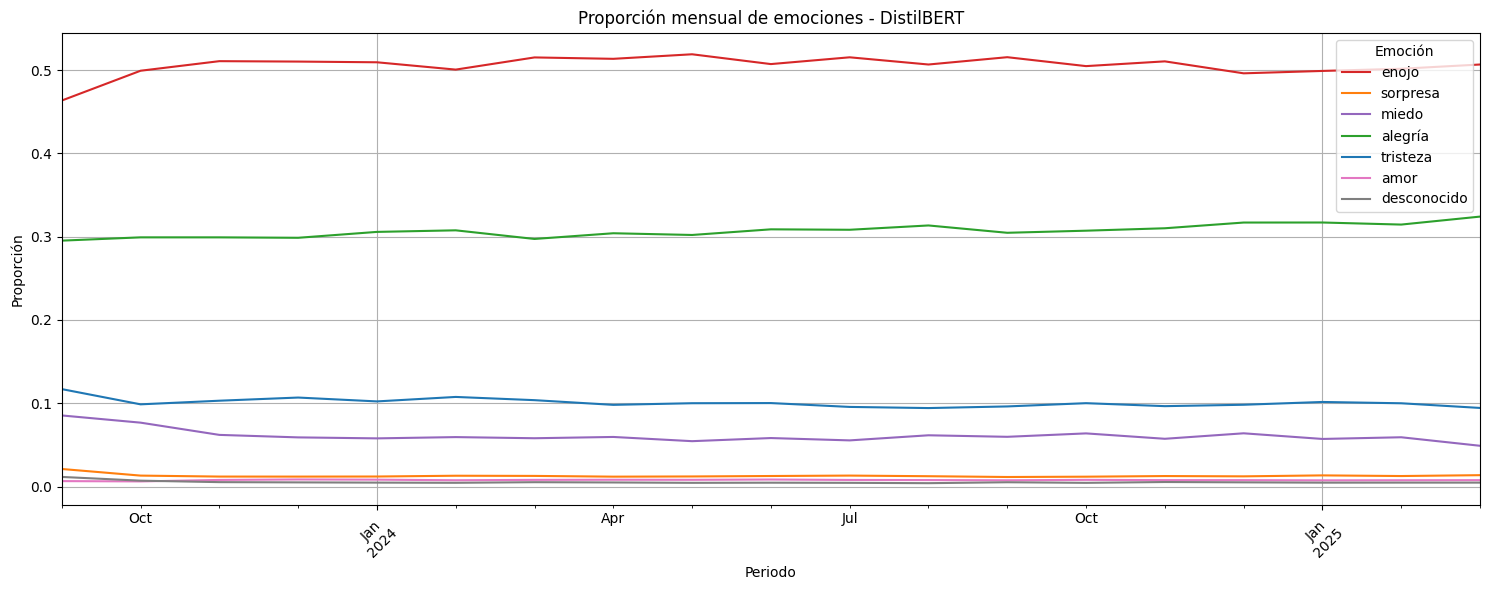

In [79]:
# Diario
daily_counts_distilbert = process_emotion_counts_by_period(df_distilbert_translated, period="D")
plot_emotion_counts_by_period(daily_counts_distilbert, "Evolución diaria de emociones - DistilBERT")
plot_emotion_proportions_by_period(daily_counts_distilbert, "Proporción diaria de emociones - DistilBERT")

# Semanal
weekly_counts_distilbert = process_emotion_counts_by_period(df_distilbert_translated, period="W")
plot_emotion_counts_by_period(weekly_counts_distilbert, "Evolución semanal de emociones - DistilBERT")
plot_emotion_proportions_by_period(weekly_counts_distilbert, "Proporción semanal de emociones - DistilBERT")

# Mensual
monthly_counts_distilbert = process_emotion_counts_by_period(df_distilbert_translated, period="M")
plot_emotion_counts_by_period(monthly_counts_distilbert, "Evolución mensual de emociones - DistilBERT")
plot_emotion_proportions_by_period(monthly_counts_distilbert, "Proporción mensual de emociones - DistilBERT")

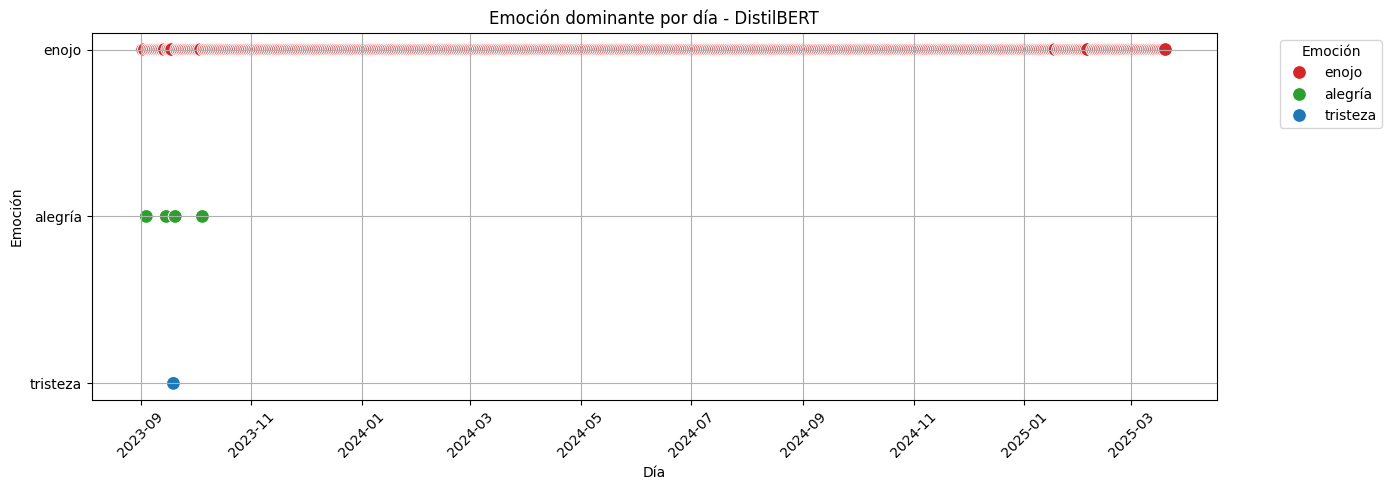

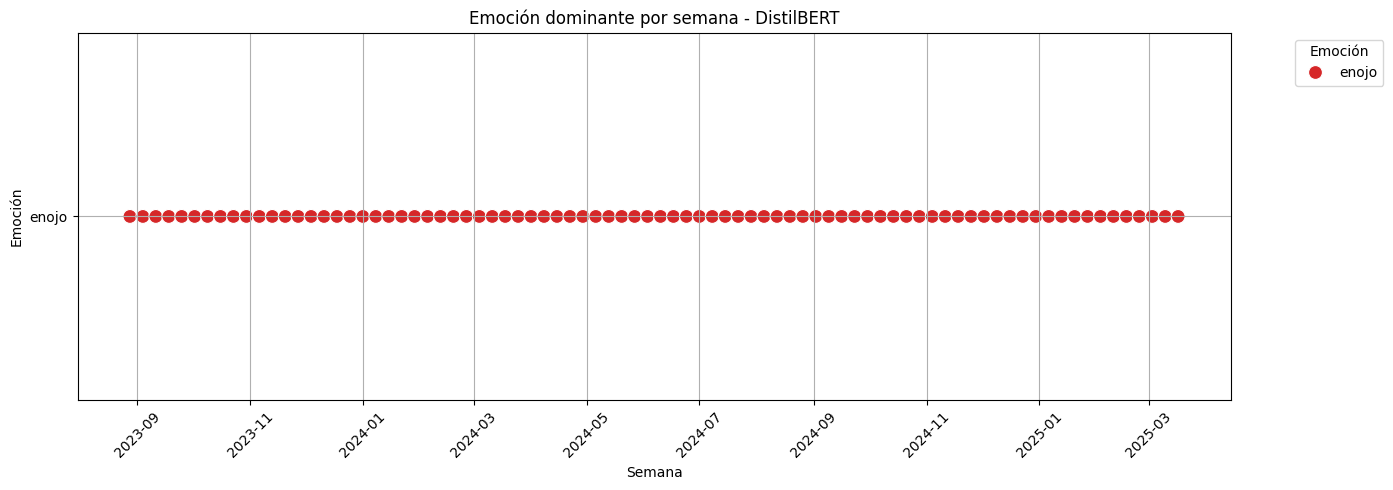

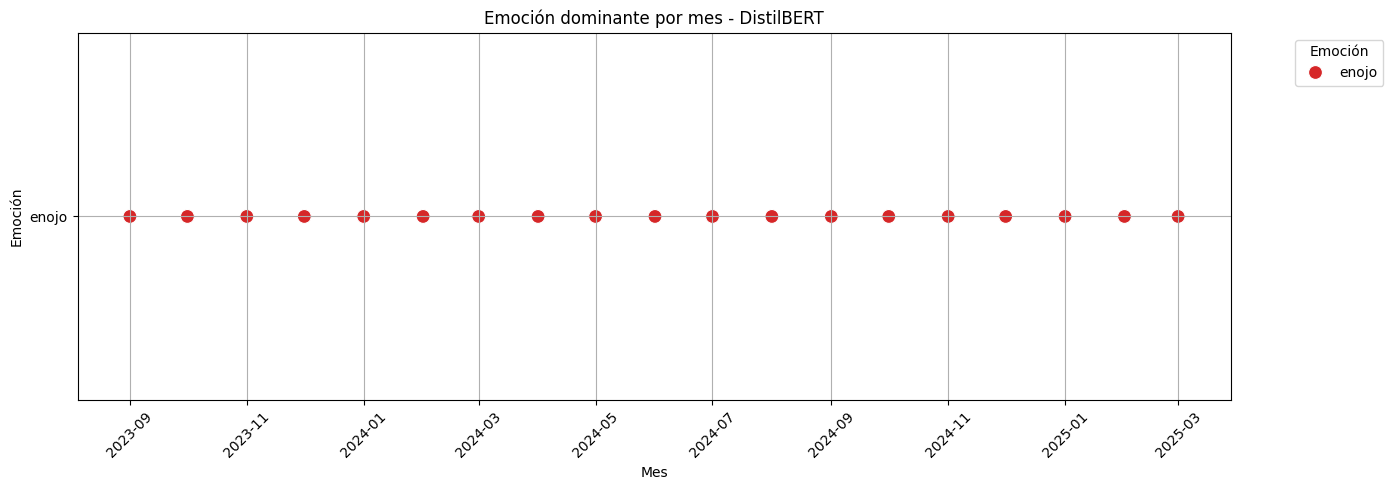

In [117]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_distilbert,
    title="Emoción dominante por día - DistilBERT",
    x_label="Día",
    period_type="día"
)

# Para datos semanales
plot_dominant_emotion(
    weekly_counts_distilbert,
    title="Emoción dominante por semana - DistilBERT",
    x_label="Semana",
    period_type="semana"
)

# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_distilbert,
    title="Emoción dominante por mes - DistilBERT",
    x_label="Mes",
    period_type="mes"
)

## Modelo T5

In [80]:
df_t5 = pd.read_csv("../data/chunks_t5/reddit_emotions_replace.csv")
df_t5_translated = translate_emotions(df_t5, "predicted_emotion")

df_t5_emotion_count = get_emotions_count(df_t5_translated, "predicted_emotion")

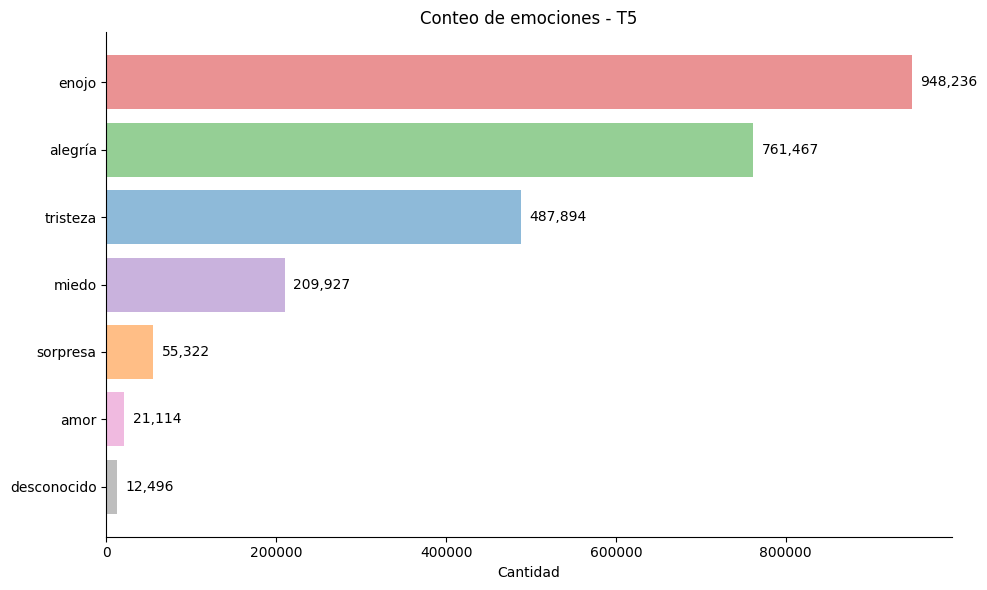

In [81]:
plot_emotions_count(df_t5_emotion_count, title="Conteo de emociones - T5")

<Figure size 1400x600 with 0 Axes>

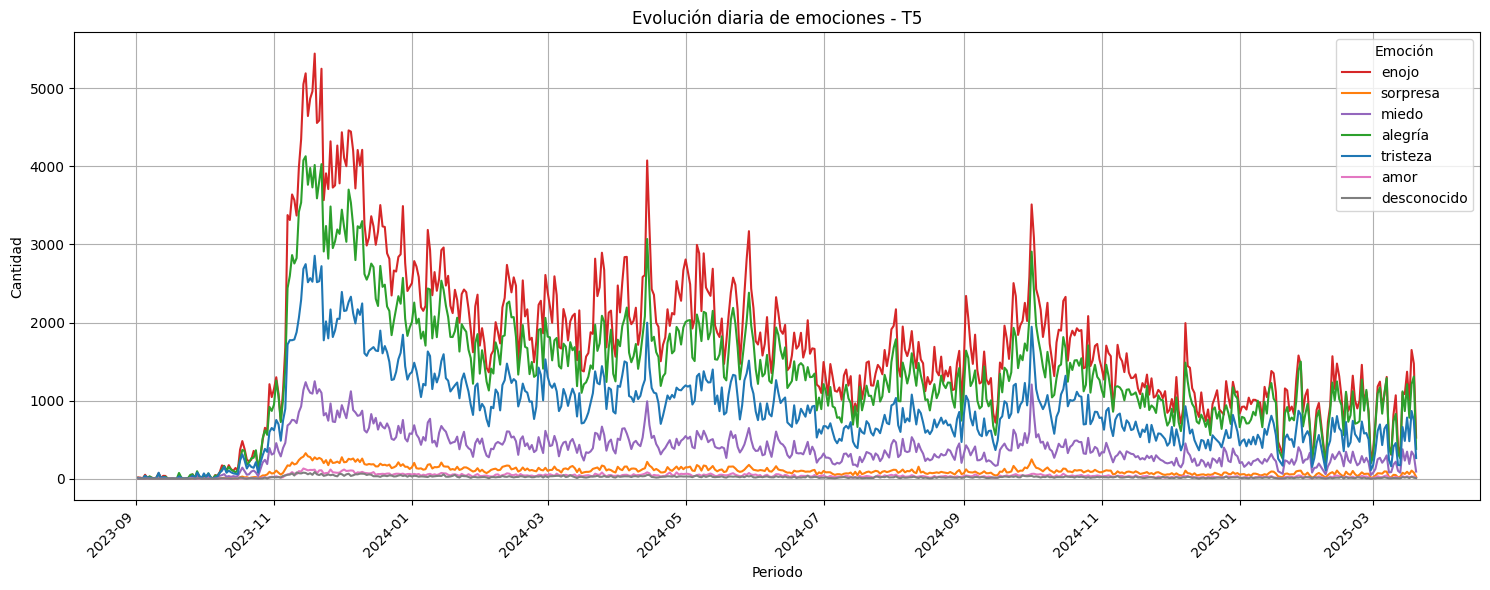

<Figure size 1400x600 with 0 Axes>

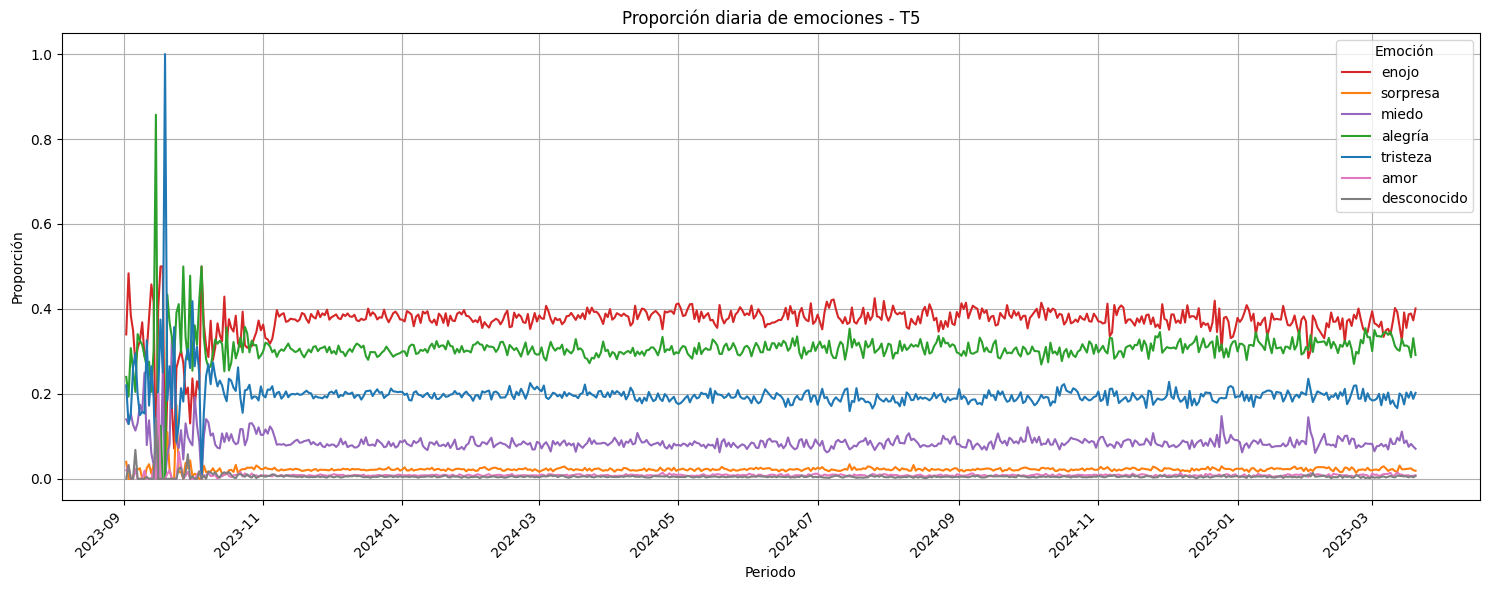

<Figure size 1400x600 with 0 Axes>

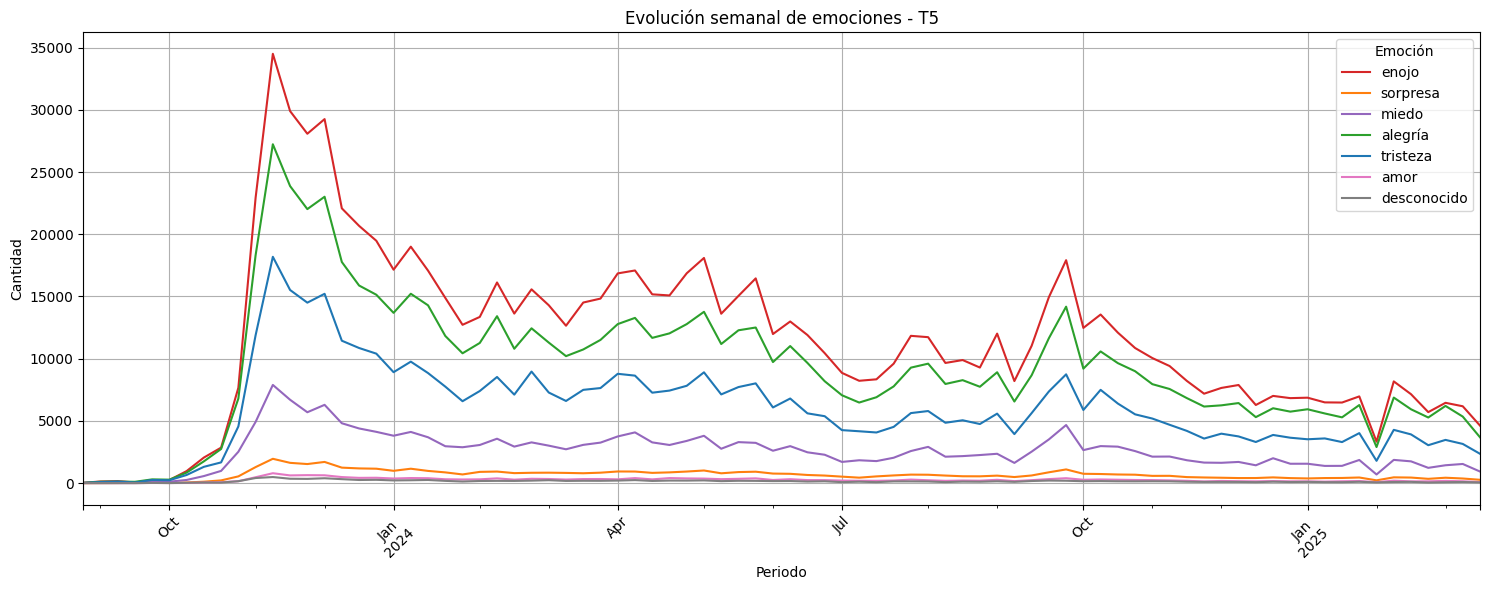

<Figure size 1400x600 with 0 Axes>

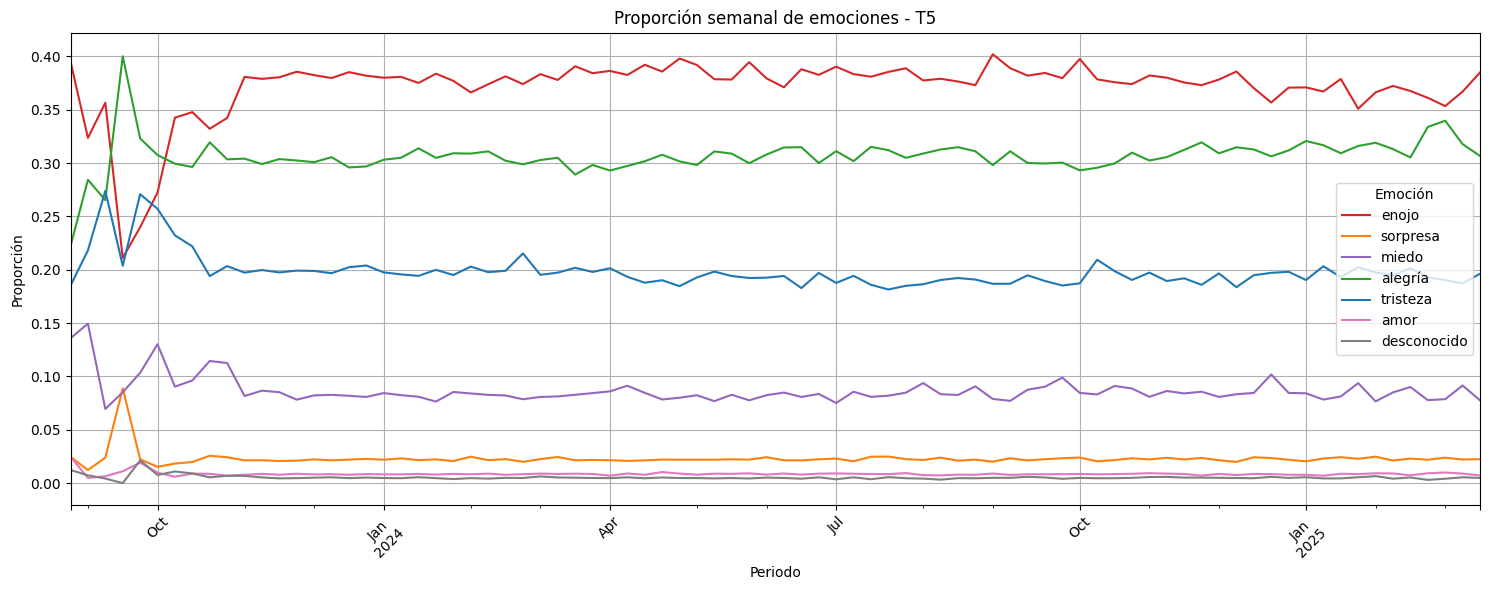

<Figure size 1400x600 with 0 Axes>

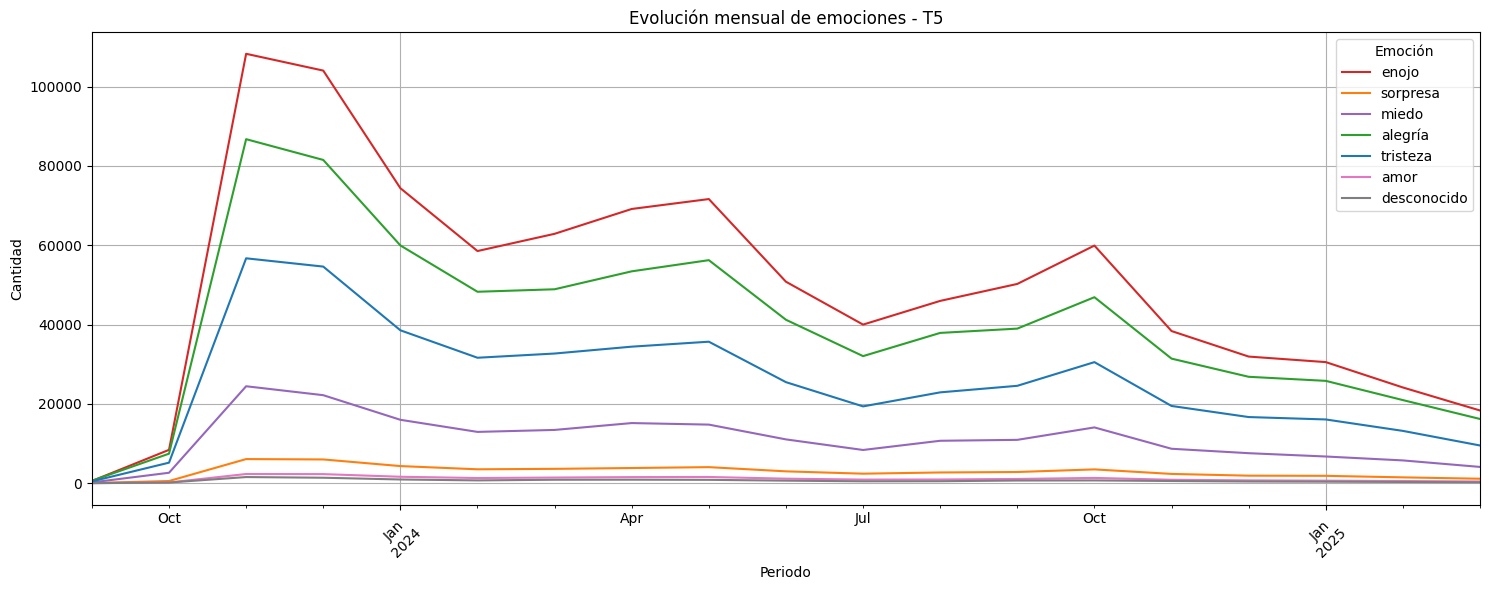

<Figure size 1400x600 with 0 Axes>

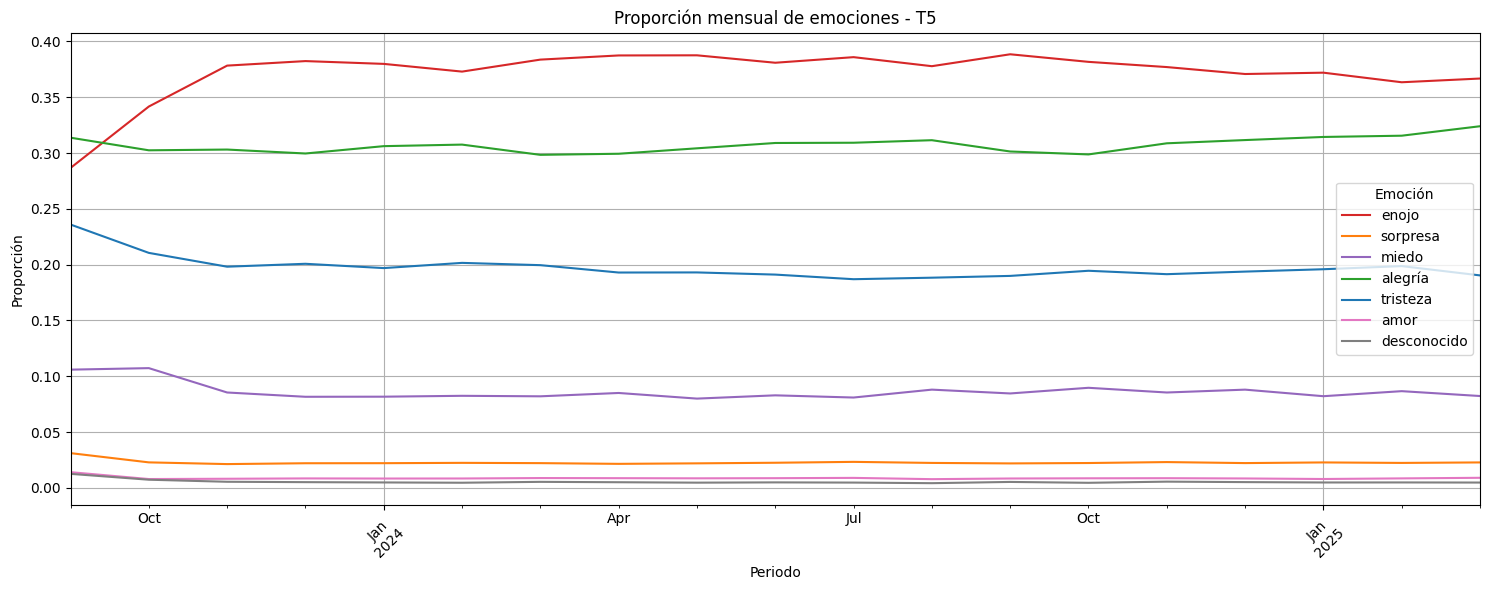

In [82]:
# Diario
daily_counts_t5 = process_emotion_counts_by_period(df_t5_translated, period="D")
plot_emotion_counts_by_period(daily_counts_t5, "Evolución diaria de emociones - T5")
plot_emotion_proportions_by_period(daily_counts_t5, "Proporción diaria de emociones - T5")

# Semanal
weekly_counts_t5 = process_emotion_counts_by_period(df_t5_translated, period="W")
plot_emotion_counts_by_period(weekly_counts_t5, "Evolución semanal de emociones - T5")
plot_emotion_proportions_by_period(weekly_counts_t5, "Proporción semanal de emociones - T5")

# Mensual
monthly_counts_t5 = process_emotion_counts_by_period(df_t5_translated, period="M")
plot_emotion_counts_by_period(monthly_counts_t5, "Evolución mensual de emociones - T5")
plot_emotion_proportions_by_period(monthly_counts_t5, "Proporción mensual de emociones - T5")

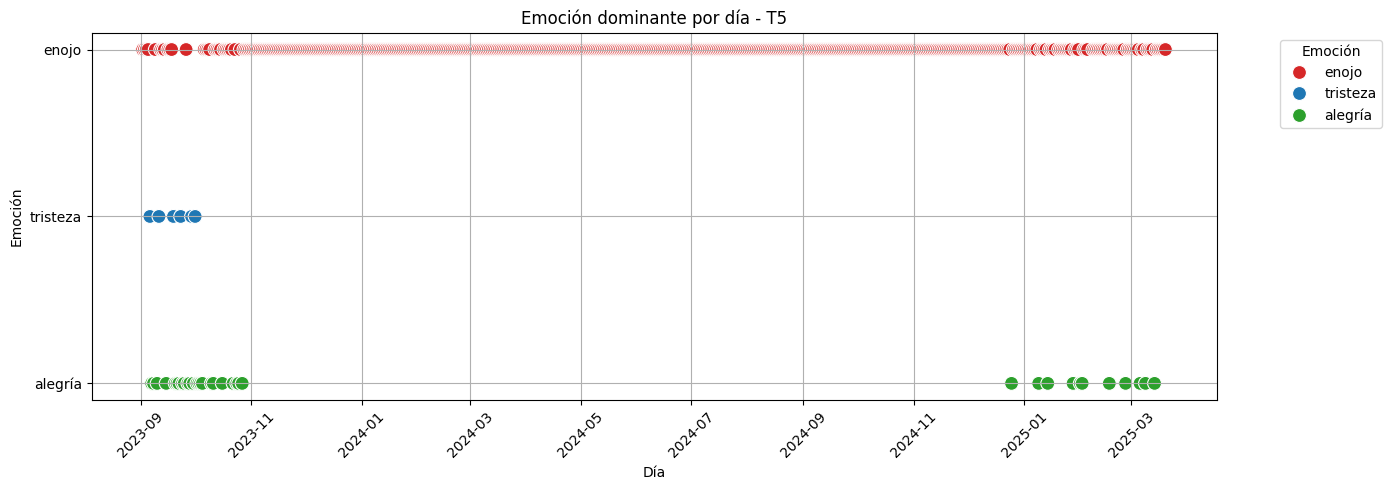

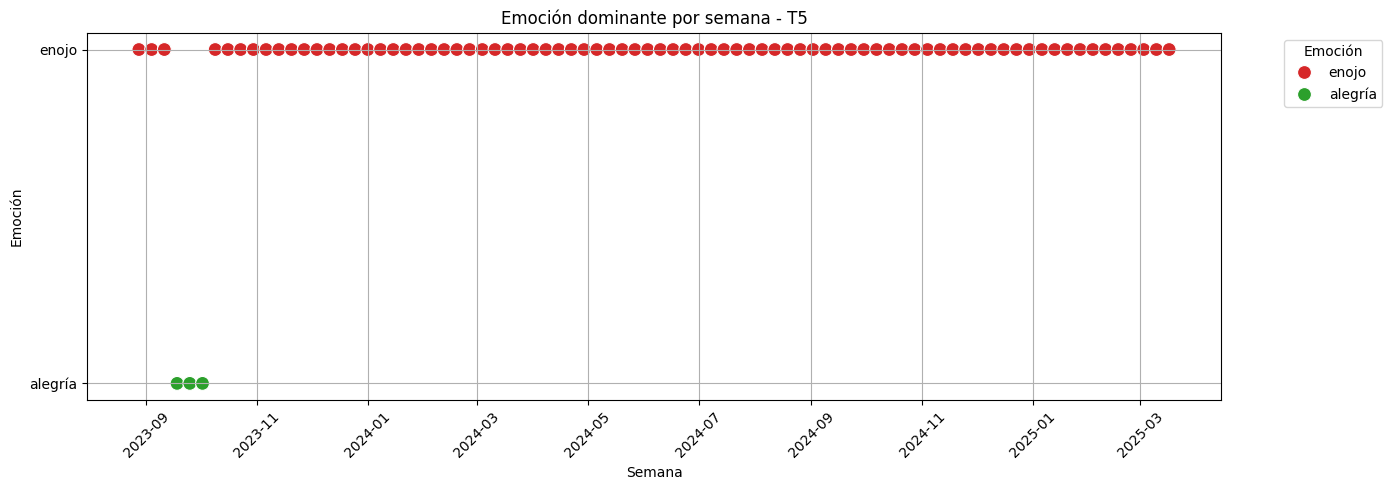

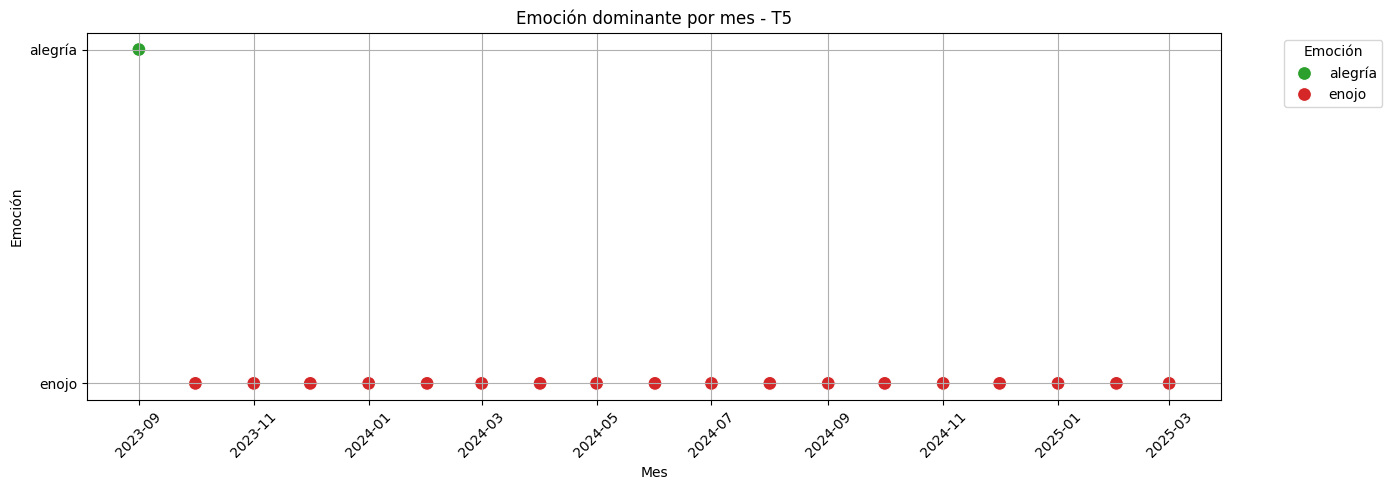

In [118]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_t5,
    title="Emoción dominante por día - T5",
    x_label="Día",
    period_type="día"
)
# Para datos semanales
plot_dominant_emotion(
    weekly_counts_t5,
    title="Emoción dominante por semana - T5",
    x_label="Semana",
    period_type="semana"
)
# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_t5,
    title="Emoción dominante por mes - T5",
    x_label="Mes",
    period_type="mes"
)

## Modelo Roberta

In [83]:
df_roberta = pd.read_csv("../data/chunks_roberta/reddit_emotions.csv")
df_roberta_translated = translate_emotions(df_roberta, "predicted_emotion")

df_roberta_emotion_count = get_emotions_count(df_roberta_translated, "predicted_emotion")

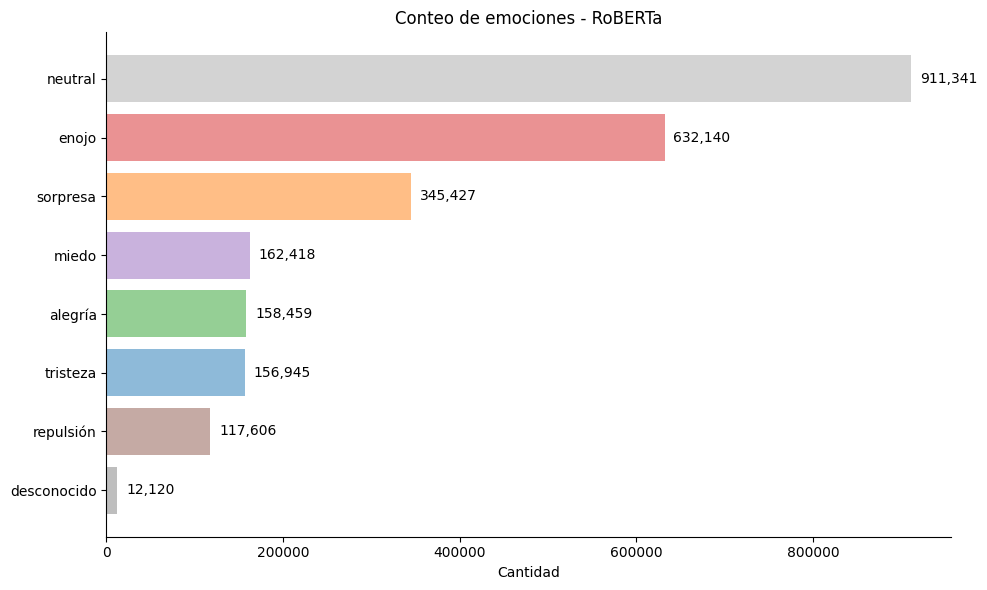

In [84]:
plot_emotions_count(df_roberta_emotion_count, title="Conteo de emociones - RoBERTa")

<Figure size 1400x600 with 0 Axes>

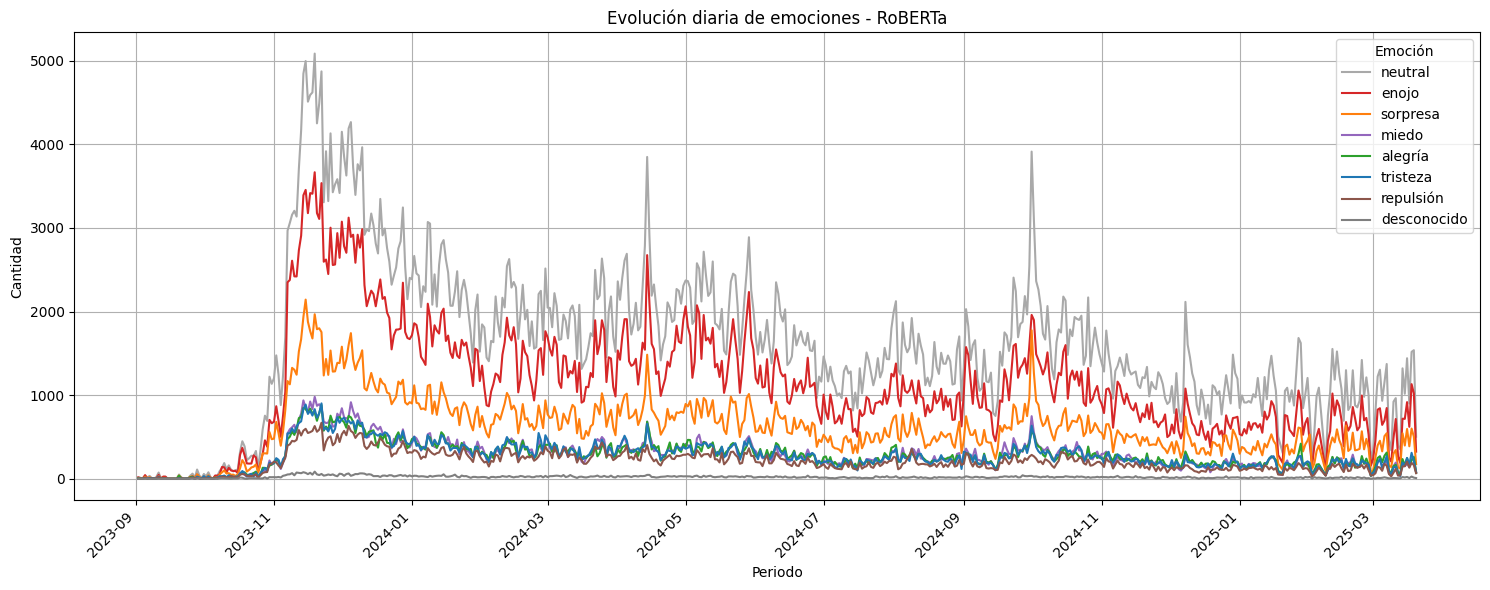

<Figure size 1400x600 with 0 Axes>

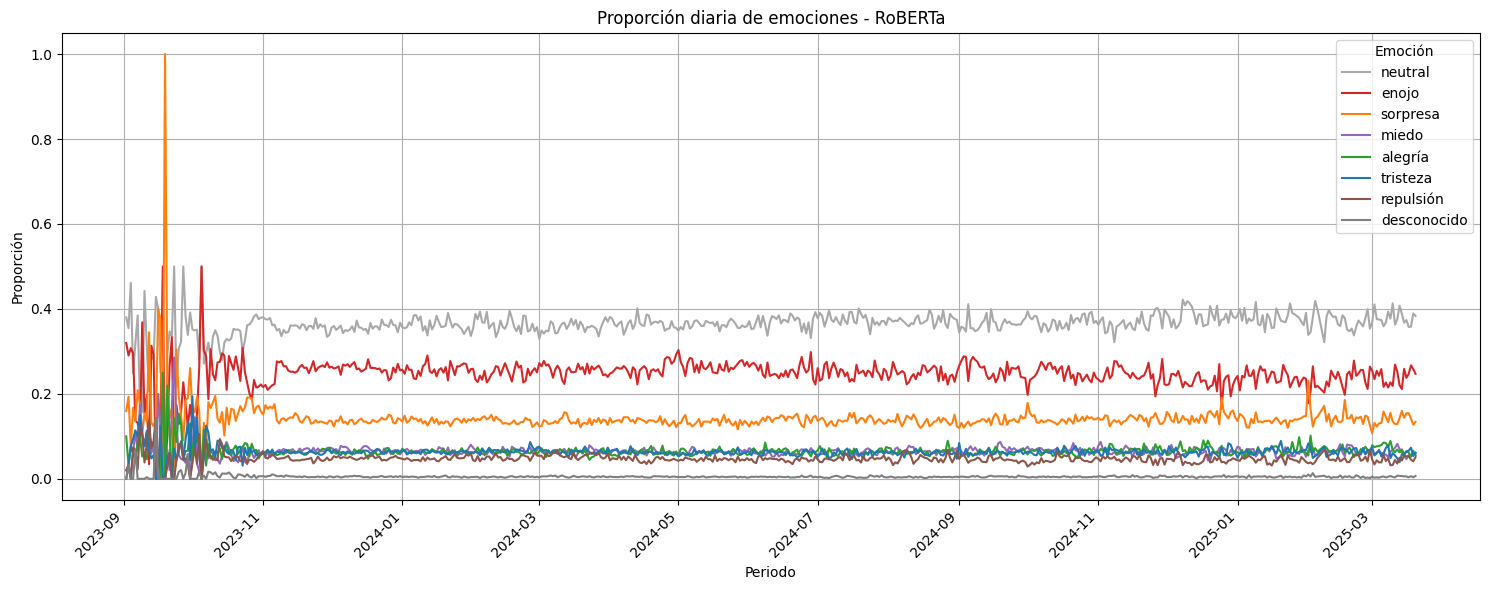

<Figure size 1400x600 with 0 Axes>

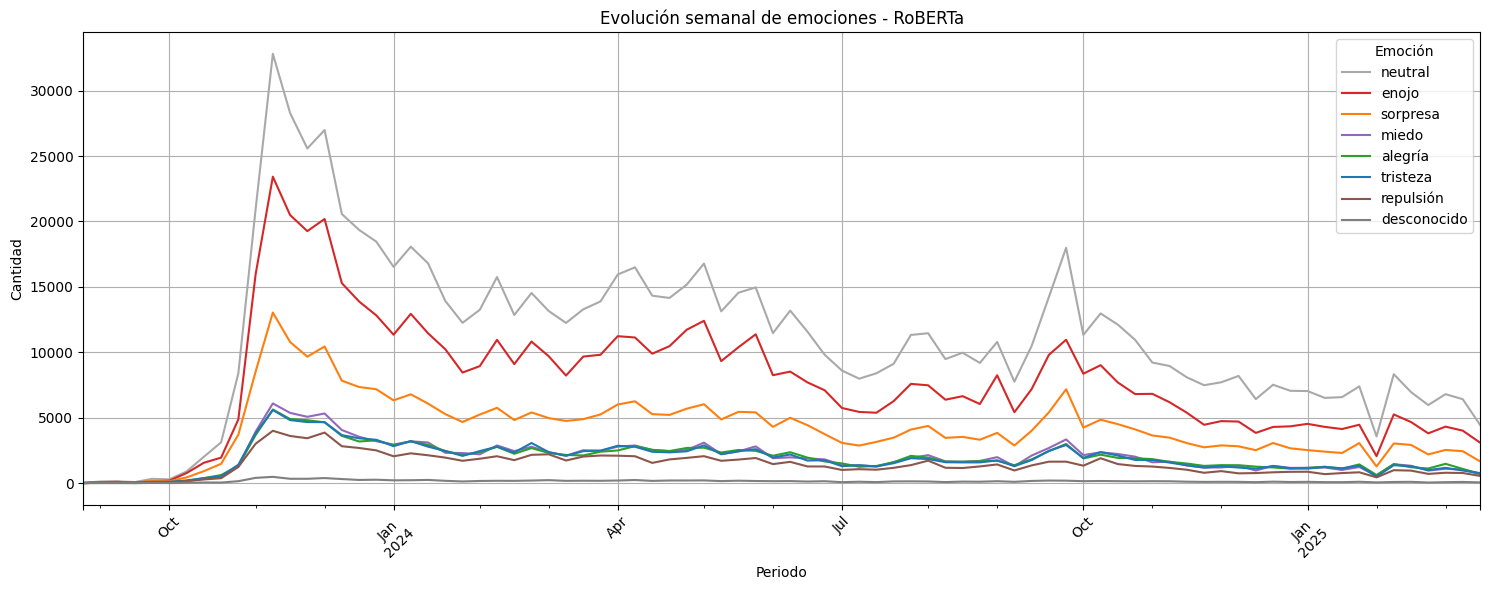

<Figure size 1400x600 with 0 Axes>

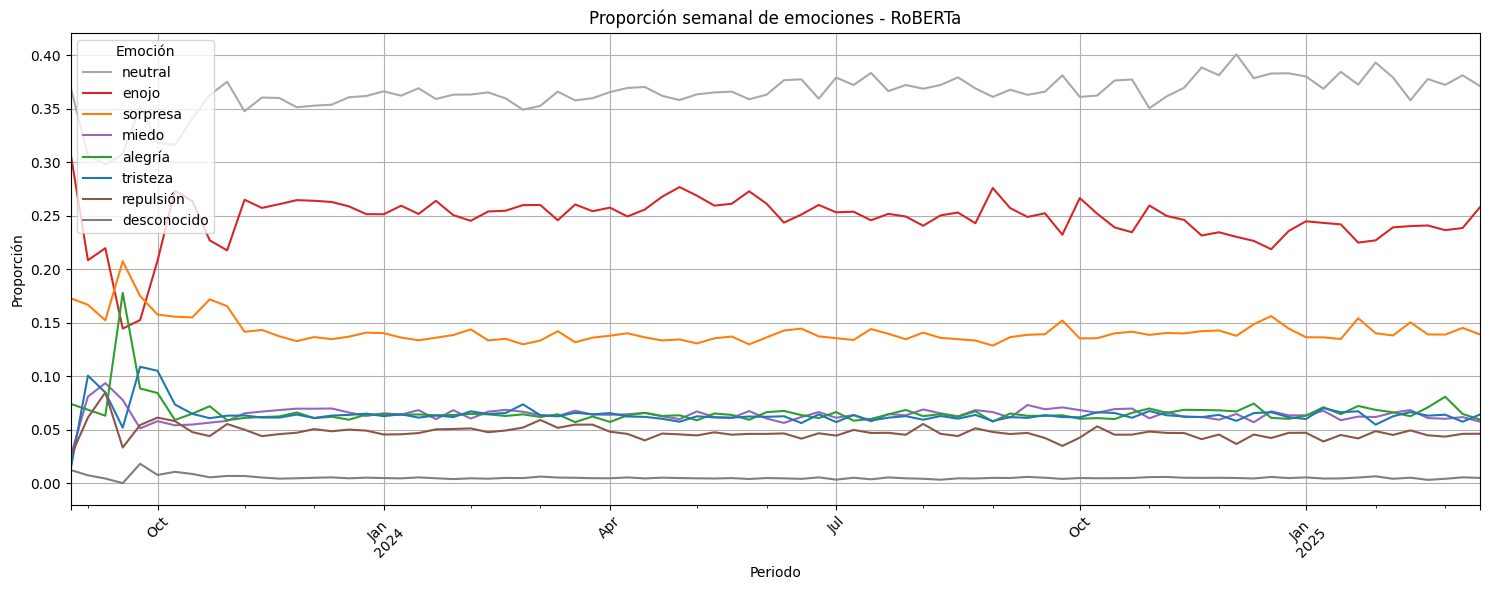

<Figure size 1400x600 with 0 Axes>

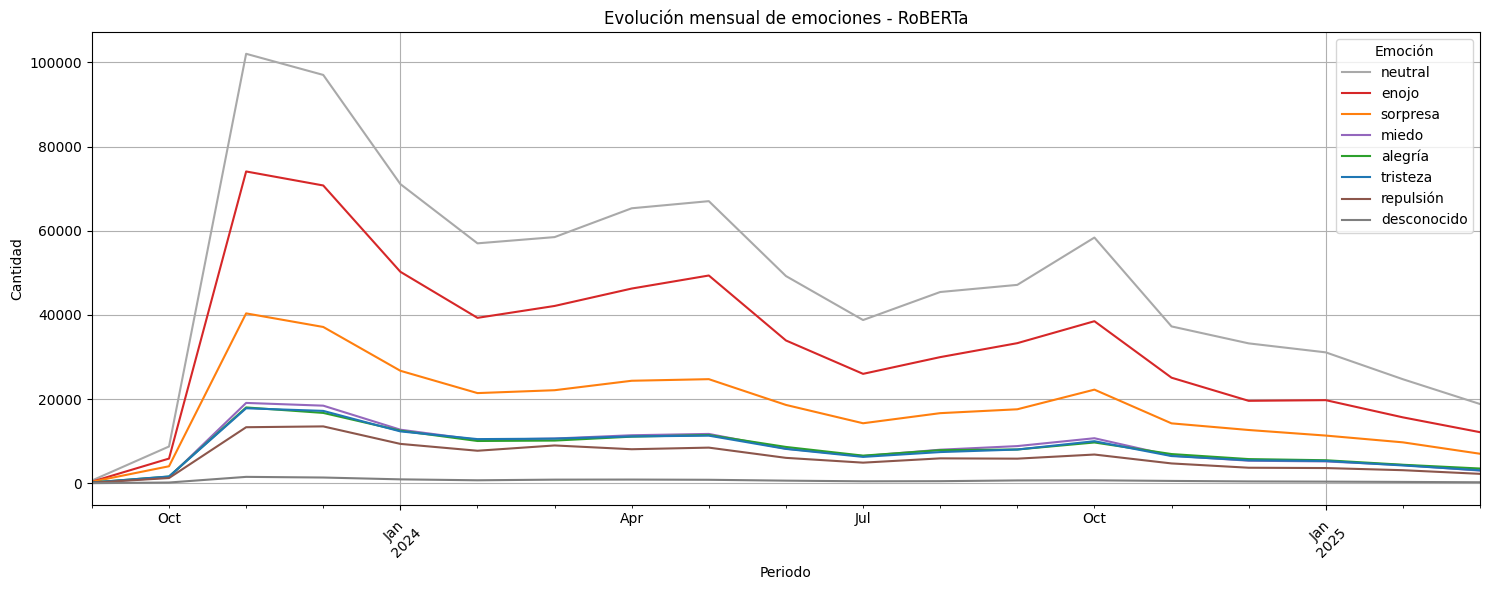

<Figure size 1400x600 with 0 Axes>

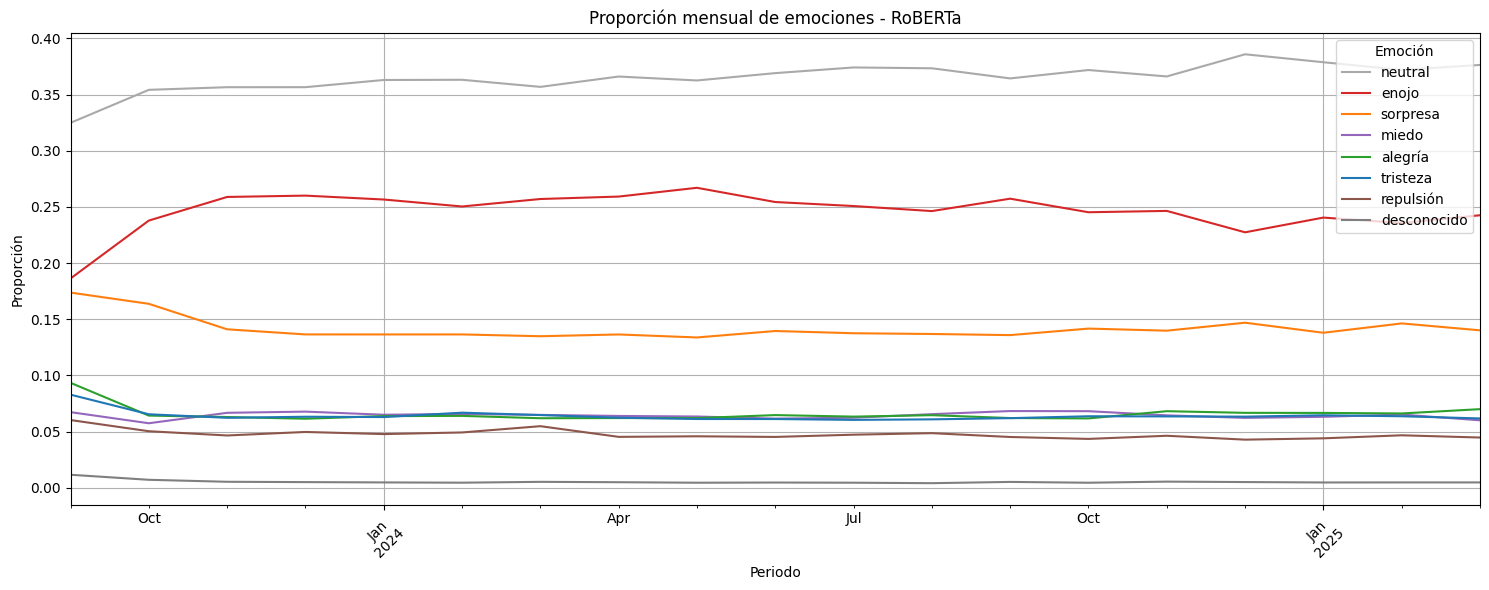

In [85]:
# Diario
daily_counts_roberta = process_emotion_counts_by_period(df_roberta_translated, period="D")
plot_emotion_counts_by_period(daily_counts_roberta, "Evolución diaria de emociones - RoBERTa")
plot_emotion_proportions_by_period(daily_counts_roberta, "Proporción diaria de emociones - RoBERTa")

# Semanal
weekly_counts_roberta = process_emotion_counts_by_period(df_roberta_translated, period="W")
plot_emotion_counts_by_period(weekly_counts_roberta, "Evolución semanal de emociones - RoBERTa")
plot_emotion_proportions_by_period(weekly_counts_roberta, "Proporción semanal de emociones - RoBERTa")

# Mensual
monthly_counts_roberta = process_emotion_counts_by_period(df_roberta_translated, period="M")
plot_emotion_counts_by_period(monthly_counts_roberta, "Evolución mensual de emociones - RoBERTa")
plot_emotion_proportions_by_period(monthly_counts_roberta, "Proporción mensual de emociones - RoBERTa")

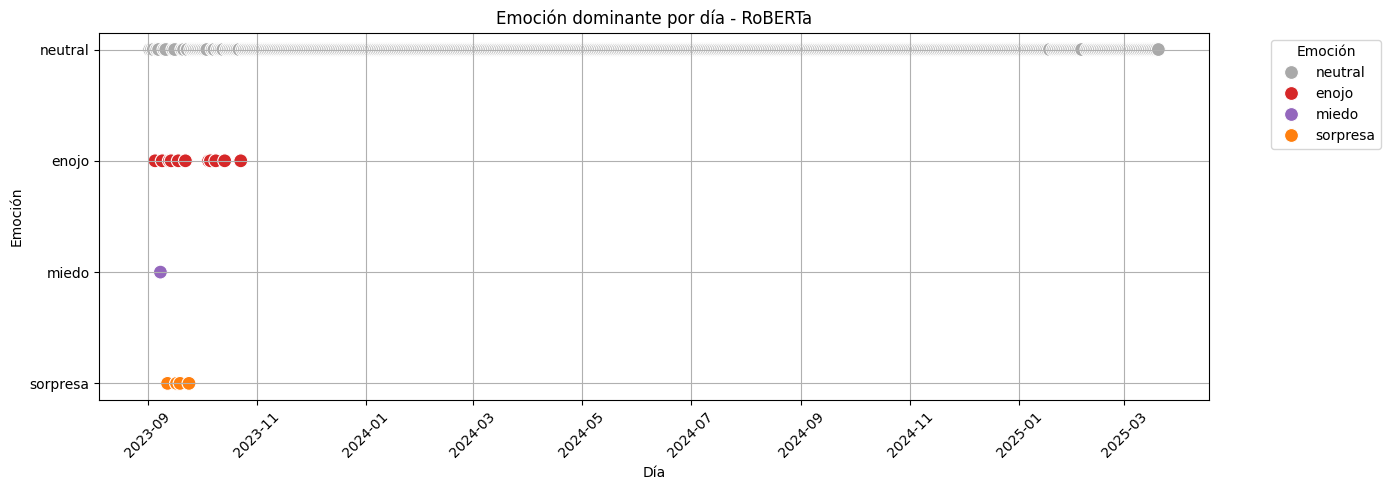

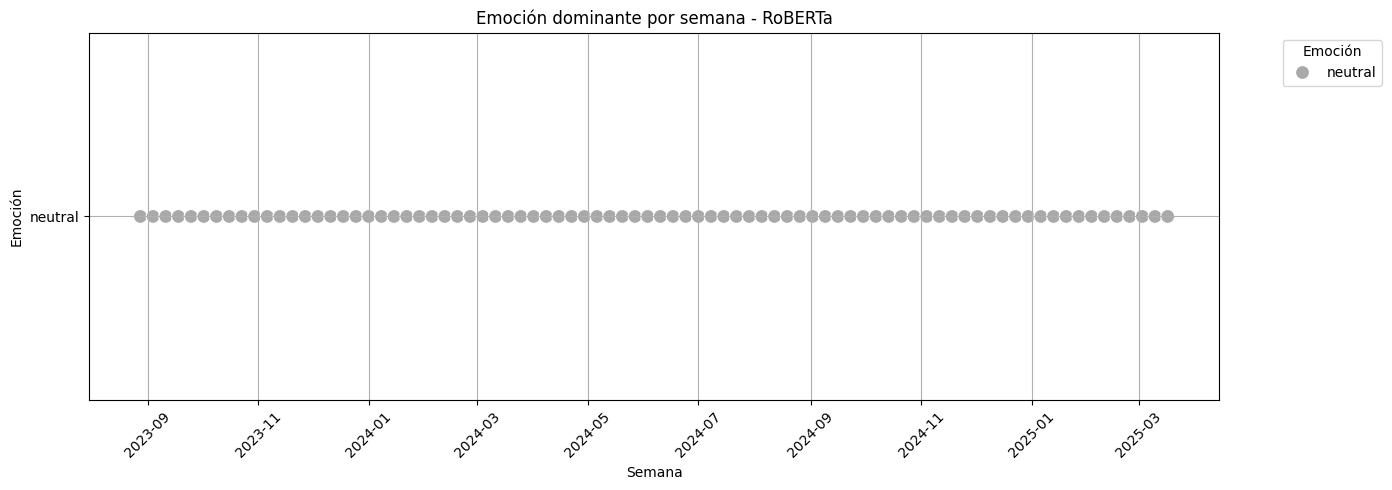

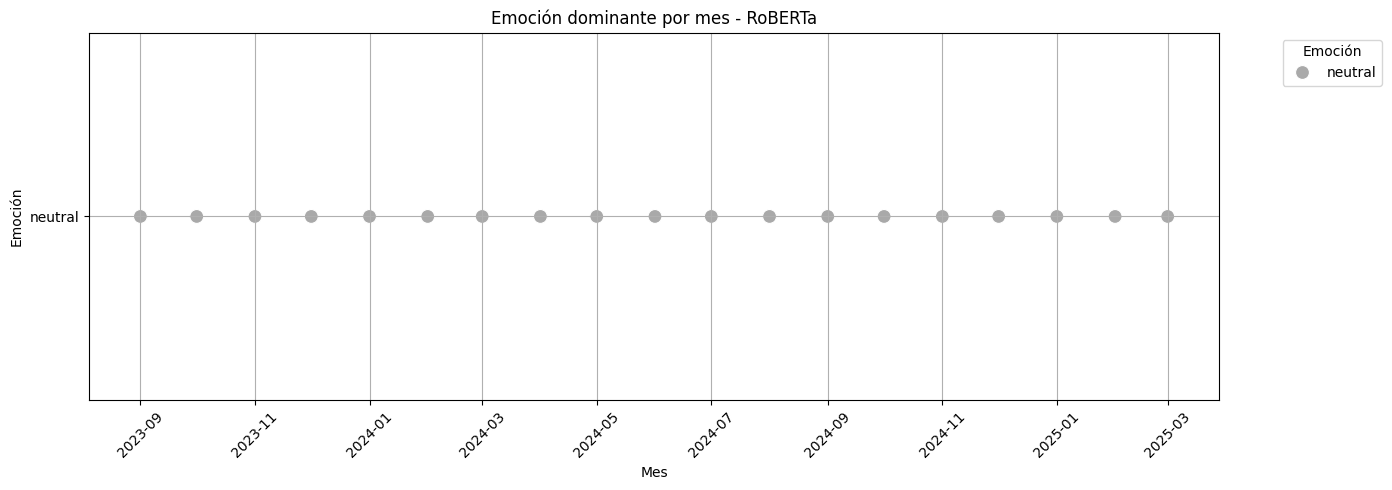

In [119]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_roberta,
    title="Emoción dominante por día - RoBERTa",
    x_label="Día",
    period_type="día",
)
# Para datos semanales
plot_dominant_emotion(
    weekly_counts_roberta,
    title="Emoción dominante por semana - RoBERTa",
    x_label="Semana",
    period_type="semana"
)
# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_roberta,
    title="Emoción dominante por mes - RoBERTa",
    x_label="Mes",
    period_type="mes"
)

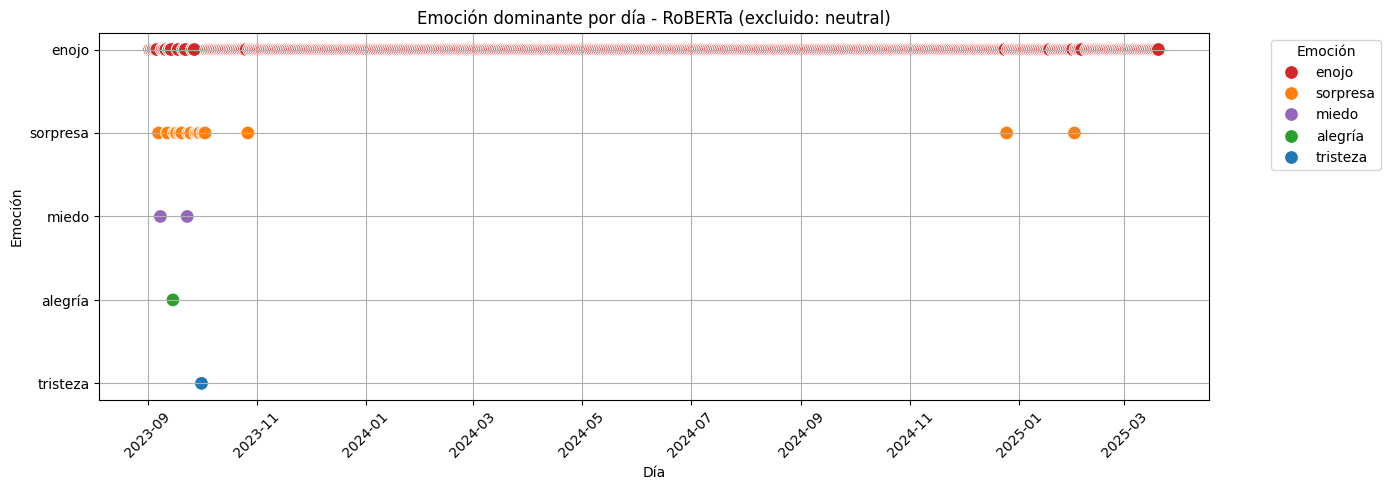

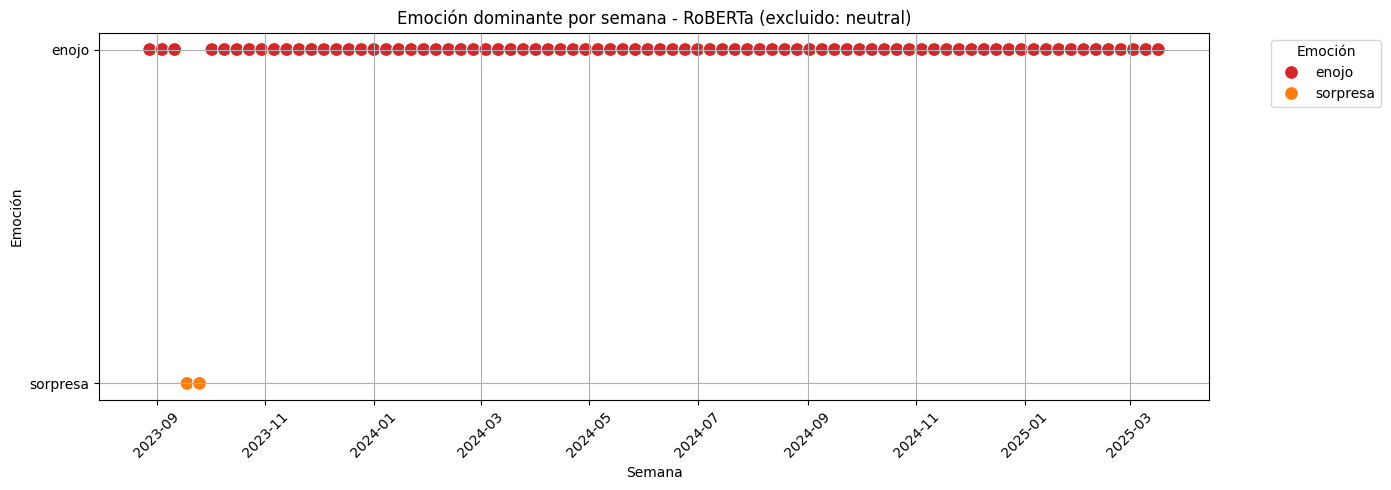

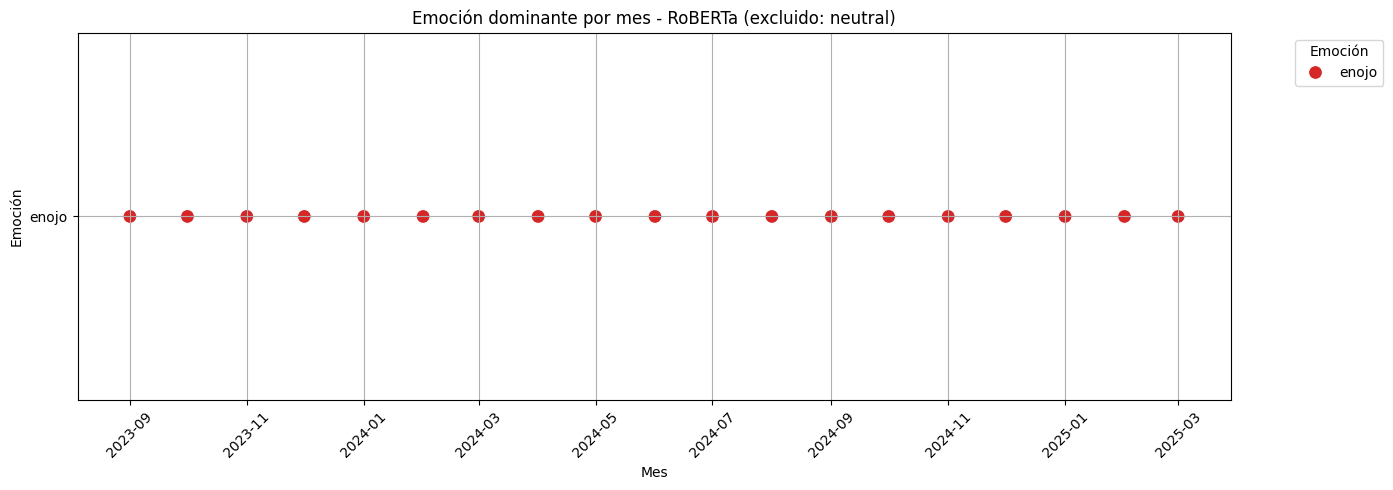

In [120]:
# Para datos diarios
plot_dominant_emotion(
    daily_counts_roberta,
    title="Emoción dominante por día - RoBERTa",
    x_label="Día",
    period_type="día",
    exclude_emotions=["neutral"]
)
# Para datos semanales
plot_dominant_emotion(
    weekly_counts_roberta,
    title="Emoción dominante por semana - RoBERTa",
    x_label="Semana",
    period_type="semana",
    exclude_emotions=["neutral"]
)
# Para datos mensuales
plot_dominant_emotion(
    monthly_counts_roberta,
    title="Emoción dominante por mes - RoBERTa",
    x_label="Mes",
    period_type="mes",
    exclude_emotions=["neutral"]
)

In [123]:
props_distilbert = get_monthly_proportions(df_distilbert, "DistilBERT")
props_t5         = get_monthly_proportions(df_t5, "T5")
props_roberta    = get_monthly_proportions(df_roberta, "RoBERTa")


Proporciones promedio mensuales – DistilBERT
predicted_emotion
enojo          0.5054
alegría        0.3070
tristeza       0.1007
miedo          0.0609
sorpresa       0.0129
amor           0.0077
desconocido    0.0053
dtype: float64

Proporciones promedio mensuales – T5
predicted_emotion
enojo          0.3719
alegría        0.3073
tristeza       0.1974
miedo          0.0864
sorpresa       0.0228
amor           0.0087
desconocido    0.0055
dtype: float64

Proporciones promedio mensuales – RoBERTa
predicted_emotion
neutral        0.3650
enojo          0.2463
sorpresa       0.1418
alegría        0.0657
miedo          0.0643
tristeza       0.0640
repulsión      0.0475
desconocido    0.0053
dtype: float64


In [135]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

# Función mejorada para detectar múltiples picos por emoción
def detectar_picos_multiples(df, modelo, prominencia=10000):
    resultados = []
    for emocion in df.columns:
        serie = df[emocion].values
        indices, _ = find_peaks(serie, prominence=prominencia)
        fechas = df.index[indices]
        valores = serie[indices]
        for fecha, valor in zip(fechas, valores):
            resultados.append((modelo, emocion, fecha.strftime("%Y-%m"), int(valor)))
    return resultados

# Mostramos una tabla de ejemplo con el DataFrame de T5 si está disponible
# Simulación de datos si no está presente
try:
    monthly_counts_t5
except NameError:
    # Simulación de un DataFrame con índices mensuales y algunas emociones
    date_range = pd.date_range(start="2023-09-01", periods=18, freq="MS")
    data = {
        "enojo": np.random.randint(10000, 100000, size=len(date_range)),
        "alegría": np.random.randint(8000, 90000, size=len(date_range)),
        "tristeza": np.random.randint(5000, 60000, size=len(date_range)),
    }
    monthly_counts_t5 = pd.DataFrame(data, index=date_range)

# Ejecutar detección de picos
picos_t5_multiples = detectar_picos_multiples(monthly_counts_t5, modelo="T5", prominencia=10000)

# Convertir a DataFrame para visualización
df_picos_t5 = pd.DataFrame(picos_t5_multiples, columns=["Modelo", "Emoción", "Mes con pico", "Cantidad"])

df_picos_t5

Modelo   Emoción Mes con pico  Cantidad
0     T5   alegría      2023-11     86747
1     T5   alegría      2024-10     46903
2     T5     enojo      2023-11    108271
3     T5     enojo      2024-05     71649
4     T5     enojo      2024-10     59923
5     T5     miedo      2023-11     24454
6     T5  tristeza      2023-11     56712
7     T5  tristeza      2024-10     30536